# Download Data

In [ ]:
from google.colab import files

# Install Kaggle library
!pip install -q kaggle
# Upload kaggle API key file
uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
#download dataset
!kaggle datasets download -d bulentsiyah/semantic-drone-dataset
!unzip '/content/semantic-drone-dataset.zip'

# Pre Processing

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install segmentation-models-pytorch
!pip install torchsummary
from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocessing

In [4]:
IMAGE_PATH = '/content/semantic_drone_dataset/original_images/'
MASK_PATH = '/content/semantic_drone_dataset/label_images_semantic/'


n_classes = 23 
# tree, gras, other vegetation, dirt, gravel, rocks, water, 
#paved area, pool, person, dog, car, bicycle, roof, wall, fence, 
#fence-pole, window, door, obstacle

#read file id in directory
name = []
for dirname, _, filenames in os.walk(IMAGE_PATH):
    for filename in filenames:
        name.append(filename.split('.')[0])

df = pd.DataFrame({'id': name}, index = np.arange(0, len(name)))
print('Number of Data: ', len(df))

#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Number of Data:  400
Train Size   :  306
Val Size     :  54
Test Size    :  40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)
Uniqe Pixel Value from mask [ 0  1  2  4  5  6  8  9 10 11 13 14 15 20 21 22]


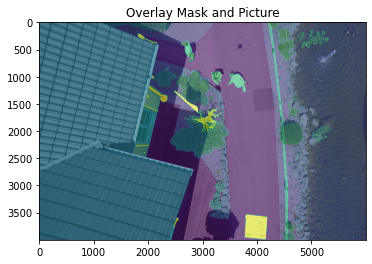

In [ ]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)
print('Uniqe Pixel Value from mask', np.unique(np.asarray(mask)))

plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Overlay Mask and Picture')
plt.show()

## Costum datasets

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
class Drone_data(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        """
        get item per index
        """
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        #transfrom different for image and mask
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):
        """
        split image into smaler patches 
        """
        #for image
        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) #tile overlap 50pixel
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) #change to total tile
        img_patches = img_patches.permute(1,0,2,3)#place the tiles number in the 0 index
        
        #for mask
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [ ]:
def calc_resize_ration(re_ration_to_depth=10, unet_depth=5, width=6000, height=4000):
    """
    calculation for image resize bacuause U-Net can only work if the size divisible by 2^depth
    example : depth 5, so the image divisible by (2^5) 8
    """
    width_to_height_rat = width/height
    unet_ratio = 2**unet_depth

    wid = unet_ratio * re_ration_to_depth * width_to_height_rat
    heig = unet_ratio * re_ration_to_depth 
    
    print('After resize with the same ration:')
    print(f' height:width = {heig, wid}')
    print(f' size after encoding can not be decimal: {heig/(2**unet_depth), wid/(2**unet_depth)}')

In [ ]:
calc_resize_ration(110)

After resize with the same ration:
 height:width = (3520, 5280.0)
 size after encoding: (110.0, 165.0)


In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = Drone_data(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = Drone_data(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               

# Model

## U-Net

In [ ]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


In [ ]:
#summary(model.cpu(), (3, 320, 480), device='cpu')

# Training

## Costum Metrics and Loss

In [5]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    """
    calculate IoU perclass pixel
    input       : pre_mask = ouput from model as prediction mask
    mask        : ground truth mask
    smooth      : for non zero devision
    n_classes   : number of class label

    return : mean over all classes
    """
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

## Lovasz Loss

In [ ]:
#source :https://github.com/bermanmaxim/LovaszSoftmax/blob/master/pytorch/lovasz_losses.py

def lovasz_softmax(probas, labels, classes='present', per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1).
              Interpreted as binary (sigmoid) output with outputs of size [B, H, W].
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = mean(lovasz_softmax_flat(*flatten_probas(prob.unsqueeze(0), lab.unsqueeze(0), ignore), classes=classes)
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_softmax_flat(*flatten_probas(probas, labels, ignore), classes=classes)
    return loss

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

def lovasz_softmax_flat(probas, labels, classes='present'):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
    """
    if probas.numel() == 0:
        # only void pixels, the gradients should be 0
        return probas * 0.
    C = probas.size(1)
    losses = []
    class_to_sum = list(range(C)) if classes in ['all', 'present'] else classes
    for c in class_to_sum:
        fg = (labels == c).float() # foreground for class c
        if (classes is 'present' and fg.sum() == 0):
            continue
        if C == 1:
            if len(classes) > 1:
                raise ValueError('Sigmoid output possible only with 1 class')
            class_pred = probas[:, 0]
        else:
            class_pred = probas[:, c]
        errors = (Variable(fg) - class_pred).abs()
        errors_sorted, perm = torch.sort(errors, 0, descending=True)
        perm = perm.data
        fg_sorted = fg[perm]
        losses.append(torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted))))
    return mean(losses)


def flatten_probas(probas, labels, ignore=None):
    """
    Flattens predictions in the batch
    """
    if probas.dim() == 3:
        # assumes output of a sigmoid layer
        B, H, W = probas.size()
        probas = probas.view(B, 1, H, W)
    B, C, H, W = probas.size()
    probas = probas.permute(0, 2, 3, 1).contiguous().view(-1, C)  # B * H * W, C = P, C
    labels = labels.view(-1)
    if ignore is None:
        return probas, labels
    valid = (labels != ignore)
    vprobas = probas[valid.nonzero().squeeze()]
    vlabels = labels[valid]
    return vprobas, vlabels

def xloss(logits, labels, ignore=None):
    """
    Cross entropy loss
    """
    return F.cross_entropy(logits, Variable(labels), ignore_index=255)


# --------------------------- HELPER FUNCTIONS ---------------------------
def isnan(x):
    return x != x
    
    
def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n

## Training

### CrossEntropy

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    """
    training loop to update the weights and bias
    epoch : number for epoch
    model : model architecture for training
    scheduler : if using sceduler

    return: history from training loss and evaluation metrics
    """
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, '/content/drive/My Drive/Colab Notebooks/models/Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:
max_lr = 1e-3 #1e-4
epoch = 30
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)


Loss Decreasing.. inf >> 2.289 
Epoch:1/30.. Train Loss: 2.985.. Val Loss: 2.289.. Train mIoU:0.049.. Val mIoU: 0.138.. Train Acc:0.153.. Val Acc:0.546.. Time: 4.84m



Loss Decreasing.. 2.289 >> 1.490 
Epoch:2/30.. Train Loss: 2.188.. Val Loss: 1.490.. Train mIoU:0.133.. Val mIoU: 0.166.. Train Acc:0.582.. Val Acc:0.710.. Time: 4.86m



Loss Decreasing.. 1.490 >> 1.155 
Epoch:3/30.. Train Loss: 1.595.. Val Loss: 1.155.. Train mIoU:0.149.. Val mIoU: 0.168.. Train Acc:0.646.. Val Acc:0.714.. Time: 4.76m



Loss Decreasing.. 1.155 >> 1.050 
saving model...
Epoch:4/30.. Train Loss: 1.368.. Val Loss: 1.050.. Train mIoU:0.147.. Val mIoU: 0.168.. Train Acc:0.647.. Val Acc:0.720.. Time: 4.80m



Loss Decreasing.. 1.050 >> 0.992 
Epoch:5/30.. Train Loss: 1.288.. Val Loss: 0.992.. Train mIoU:0.155.. Val mIoU: 0.183.. Train Acc:0.645.. Val Acc:0.730.. Time: 4.73m



Loss Decreasing.. 0.992 >> 0.983 
Epoch:6/30.. Train Loss: 1.170.. Val Loss: 0.983.. Train mIoU:0.168.. Val mIoU: 0.193.. Train Acc:0.666.. Val Acc:0.715.. Time: 4.71m



Loss Decreasing.. 0.983 >> 0.917 
Epoch:7/30.. Train Loss: 1.111.. Val Loss: 0.917.. Train mIoU:0.185.. Val mIoU: 0.220.. Train Acc:0.682.. Val Acc:0.736.. Time: 4.70m



Loss Decreasing.. 0.917 >> 0.879 
Epoch:8/30.. Train Loss: 1.010.. Val Loss: 0.879.. Train mIoU:0.212.. Val mIoU: 0.218.. Train Acc:0.708.. Val Acc:0.743.. Time: 4.70m



Loss Not Decrease for 1 time
Epoch:9/30.. Train Loss: 1.050.. Val Loss: 1.001.. Train mIoU:0.210.. Val mIoU: 0.224.. Train Acc:0.694.. Val Acc:0.724.. Time: 4.74m



Loss Decreasing.. 1.001 >> 0.806 
saving model...
Epoch:10/30.. Train Loss: 0.980.. Val Loss: 0.806.. Train mIoU:0.220.. Val mIoU: 0.247.. Train Acc:0.711.. Val Acc:0.773.. Time: 4.71m



Loss Decreasing.. 0.806 >> 0.782 
Epoch:11/30.. Train Loss: 0.976.. Val Loss: 0.782.. Train mIoU:0.219.. Val mIoU: 0.257.. Train Acc:0.705.. Val Acc:0.772.. Time: 4.68m



Loss Decreasing.. 0.782 >> 0.774 
Epoch:12/30.. Train Loss: 0.914.. Val Loss: 0.774.. Train mIoU:0.235.. Val mIoU: 0.266.. Train Acc:0.730.. Val Acc:0.765.. Time: 4.84m



Loss Not Decrease for 2 time
Epoch:13/30.. Train Loss: 0.859.. Val Loss: 0.810.. Train mIoU:0.249.. Val mIoU: 0.257.. Train Acc:0.744.. Val Acc:0.740.. Time: 4.90m



Loss Decreasing.. 0.810 >> 0.679 
Epoch:14/30.. Train Loss: 0.795.. Val Loss: 0.679.. Train mIoU:0.263.. Val mIoU: 0.320.. Train Acc:0.765.. Val Acc:0.809.. Time: 4.90m



Loss Decreasing.. 0.679 >> 0.630 
Epoch:15/30.. Train Loss: 0.699.. Val Loss: 0.630.. Train mIoU:0.291.. Val mIoU: 0.299.. Train Acc:0.796.. Val Acc:0.812.. Time: 4.95m



Loss Not Decrease for 3 time
Epoch:16/30.. Train Loss: 0.731.. Val Loss: 0.657.. Train mIoU:0.293.. Val mIoU: 0.324.. Train Acc:0.786.. Val Acc:0.807.. Time: 4.96m



Loss Decreasing.. 0.657 >> 0.578 
saving model...
Epoch:17/30.. Train Loss: 0.711.. Val Loss: 0.578.. Train mIoU:0.306.. Val mIoU: 0.365.. Train Acc:0.791.. Val Acc:0.831.. Time: 4.95m



Loss Not Decrease for 4 time
Epoch:18/30.. Train Loss: 0.658.. Val Loss: 0.651.. Train mIoU:0.322.. Val mIoU: 0.349.. Train Acc:0.807.. Val Acc:0.807.. Time: 4.96m



Loss Decreasing.. 0.651 >> 0.564 
Epoch:19/30.. Train Loss: 0.683.. Val Loss: 0.564.. Train mIoU:0.325.. Val mIoU: 0.371.. Train Acc:0.798.. Val Acc:0.833.. Time: 4.97m



Loss Decreasing.. 0.564 >> 0.526 
Epoch:20/30.. Train Loss: 0.605.. Val Loss: 0.526.. Train mIoU:0.349.. Val mIoU: 0.380.. Train Acc:0.823.. Val Acc:0.846.. Time: 4.97m



Loss Decreasing.. 0.526 >> 0.498 
Epoch:21/30.. Train Loss: 0.547.. Val Loss: 0.498.. Train mIoU:0.371.. Val mIoU: 0.406.. Train Acc:0.839.. Val Acc:0.856.. Time: 4.97m



Loss Decreasing.. 0.498 >> 0.489 
Epoch:22/30.. Train Loss: 0.546.. Val Loss: 0.489.. Train mIoU:0.373.. Val mIoU: 0.400.. Train Acc:0.840.. Val Acc:0.860.. Time: 4.96m



Loss Decreasing.. 0.489 >> 0.456 
saving model...
Epoch:23/30.. Train Loss: 0.514.. Val Loss: 0.456.. Train mIoU:0.392.. Val mIoU: 0.397.. Train Acc:0.850.. Val Acc:0.866.. Time: 4.97m



Loss Not Decrease for 5 time
Epoch:24/30.. Train Loss: 0.489.. Val Loss: 0.466.. Train mIoU:0.407.. Val mIoU: 0.405.. Train Acc:0.858.. Val Acc:0.861.. Time: 4.87m



Loss Decreasing.. 0.466 >> 0.462 
Epoch:25/30.. Train Loss: 0.469.. Val Loss: 0.462.. Train mIoU:0.409.. Val mIoU: 0.418.. Train Acc:0.862.. Val Acc:0.865.. Time: 4.84m



Loss Decreasing.. 0.462 >> 0.446 
Epoch:26/30.. Train Loss: 0.462.. Val Loss: 0.446.. Train mIoU:0.412.. Val mIoU: 0.412.. Train Acc:0.865.. Val Acc:0.869.. Time: 4.88m



Loss Not Decrease for 6 time
Epoch:27/30.. Train Loss: 0.448.. Val Loss: 0.450.. Train mIoU:0.418.. Val mIoU: 0.421.. Train Acc:0.870.. Val Acc:0.868.. Time: 4.85m



Loss Decreasing.. 0.450 >> 0.438 
Epoch:28/30.. Train Loss: 0.449.. Val Loss: 0.438.. Train mIoU:0.421.. Val mIoU: 0.435.. Train Acc:0.870.. Val Acc:0.871.. Time: 4.86m



Loss Decreasing.. 0.438 >> 0.429 
Epoch:29/30.. Train Loss: 0.448.. Val Loss: 0.429.. Train mIoU:0.424.. Val mIoU: 0.434.. Train Acc:0.871.. Val Acc:0.874.. Time: 4.82m



Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Total time: 145.48 m


In [ ]:
torch.save(model, '/content/drive/My Drive/Colab Notebooks/models/Unet-Mobilenet_v2_mIoU-0.434.pt')

In [ ]:
column = list(history.keys())[:-1]
val = list(history.values())[:-1]
test = dict(zip(column, val))
df = pd.DataFrame.from_dict(test, orient='index')
nn_crs = df.transpose()
nn_crs.to_csv('/content/drive/My Drive/Colab Notebooks/models/history/Unet-Mobilenet_v2_cross_entropy.csv')

### Lovasz Training

In [ ]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, a=0.7):
    """
    training loop to update the weights and bias
    epoch : number for epoch
    model : model architecture for training
    scheduler : if using sceduler

    return: history from training loss and evaluation metrics
    """
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            output1 = F.softmax(output, dim=1)
            #loss
            loss1 = criterion(output, mask)
            loss2 = lovasz_softmax(output1, mask)
            loss = ((1-a)*loss1) + (a * loss2)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient

            scheduler.step() 
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    image_tiles, mask_tiles = data                  
                    image = image_tiles.to(device); mask = mask_tiles.to(device)
                    #forward
                    output = model(image)
                    output1 = F.softmax(output, dim=1)
                    #loss
                    loss1 = criterion(output, mask)
                    loss2 = lovasz_softmax(output1, mask)
                    loss = ((1-a)*loss1) + (a * loss2)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss                         
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))

            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, '/content/drive/My Drive/Colab Notebooks/models/Unet-Mobilenet_v2(lovasz)_mIoU{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:
epoch = 20
max_lr = 1e-4
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history_lovasz = fit(epoch, model, train_loader, val_loader, criterion, optimizer, scheduler=sched)


Loss Decreasing.. inf >> 0.532 
Epoch:1/20.. Train Loss: 0.535.. Val Loss: 0.532.. Train mIoU:0.423.. Val mIoU: 0.437.. Train Acc:0.874.. Val Acc:0.869.. Time: 5.54m



Loss Decreasing.. 0.532 >> 0.524 
Epoch:2/20.. Train Loss: 0.533.. Val Loss: 0.524.. Train mIoU:0.431.. Val mIoU: 0.435.. Train Acc:0.872.. Val Acc:0.872.. Time: 5.56m



Loss Not Decrease for 1 time
Epoch:3/20.. Train Loss: 0.525.. Val Loss: 0.528.. Train mIoU:0.437.. Val mIoU: 0.429.. Train Acc:0.872.. Val Acc:0.874.. Time: 5.53m



Loss Decreasing.. 0.528 >> 0.516 
Epoch:4/20.. Train Loss: 0.522.. Val Loss: 0.516.. Train mIoU:0.443.. Val mIoU: 0.454.. Train Acc:0.871.. Val Acc:0.869.. Time: 5.48m



Loss Decreasing.. 0.516 >> 0.506 
saving model...
Epoch:5/20.. Train Loss: 0.513.. Val Loss: 0.506.. Train mIoU:0.457.. Val mIoU: 0.469.. Train Acc:0.874.. Val Acc:0.873.. Time: 5.36m



Loss Decreasing.. 0.506 >> 0.495 
Epoch:6/20.. Train Loss: 0.507.. Val Loss: 0.495.. Train mIoU:0.469.. Val mIoU: 0.491.. Train Acc:0.873.. Val Acc:0.876.. Time: 5.23m



Loss Not Decrease for 2 time
Epoch:7/20.. Train Loss: 0.520.. Val Loss: 0.507.. Train mIoU:0.468.. Val mIoU: 0.466.. Train Acc:0.865.. Val Acc:0.872.. Time: 5.18m



Loss Decreasing.. 0.507 >> 0.491 
Epoch:8/20.. Train Loss: 0.495.. Val Loss: 0.491.. Train mIoU:0.483.. Val mIoU: 0.493.. Train Acc:0.876.. Val Acc:0.876.. Time: 5.20m



Loss Decreasing.. 0.491 >> 0.486 
Epoch:9/20.. Train Loss: 0.485.. Val Loss: 0.486.. Train mIoU:0.497.. Val mIoU: 0.496.. Train Acc:0.878.. Val Acc:0.878.. Time: 5.27m



Loss Decreasing.. 0.486 >> 0.484 
Epoch:10/20.. Train Loss: 0.488.. Val Loss: 0.484.. Train mIoU:0.491.. Val mIoU: 0.502.. Train Acc:0.876.. Val Acc:0.875.. Time: 5.24m



Loss Decreasing.. 0.484 >> 0.476 
saving model...
Epoch:11/20.. Train Loss: 0.476.. Val Loss: 0.476.. Train mIoU:0.504.. Val mIoU: 0.510.. Train Acc:0.879.. Val Acc:0.879.. Time: 5.25m



Loss Decreasing.. 0.476 >> 0.474 
Epoch:12/20.. Train Loss: 0.474.. Val Loss: 0.474.. Train mIoU:0.506.. Val mIoU: 0.509.. Train Acc:0.882.. Val Acc:0.883.. Time: 5.26m



Loss Decreasing.. 0.474 >> 0.471 
Epoch:13/20.. Train Loss: 0.459.. Val Loss: 0.471.. Train mIoU:0.519.. Val mIoU: 0.522.. Train Acc:0.886.. Val Acc:0.881.. Time: 5.27m



Loss Decreasing.. 0.471 >> 0.465 
Epoch:14/20.. Train Loss: 0.457.. Val Loss: 0.465.. Train mIoU:0.521.. Val mIoU: 0.518.. Train Acc:0.886.. Val Acc:0.883.. Time: 5.24m



Loss Decreasing.. 0.465 >> 0.458 
Epoch:15/20.. Train Loss: 0.457.. Val Loss: 0.458.. Train mIoU:0.520.. Val mIoU: 0.529.. Train Acc:0.887.. Val Acc:0.884.. Time: 5.23m



Loss Not Decrease for 3 time
Epoch:16/20.. Train Loss: 0.456.. Val Loss: 0.472.. Train mIoU:0.523.. Val mIoU: 0.513.. Train Acc:0.888.. Val Acc:0.883.. Time: 5.22m



Loss Decreasing.. 0.472 >> 0.470 
saving model...
Epoch:17/20.. Train Loss: 0.449.. Val Loss: 0.470.. Train mIoU:0.528.. Val mIoU: 0.510.. Train Acc:0.891.. Val Acc:0.884.. Time: 5.24m



Loss Decreasing.. 0.470 >> 0.457 
Epoch:18/20.. Train Loss: 0.445.. Val Loss: 0.457.. Train mIoU:0.531.. Val mIoU: 0.532.. Train Acc:0.891.. Val Acc:0.884.. Time: 5.32m



Loss Not Decrease for 4 time
Epoch:19/20.. Train Loss: 0.451.. Val Loss: 0.467.. Train mIoU:0.527.. Val mIoU: 0.516.. Train Acc:0.890.. Val Acc:0.884.. Time: 5.31m



Loss Decreasing.. 0.467 >> 0.466 
Epoch:20/20.. Train Loss: 0.447.. Val Loss: 0.466.. Train mIoU:0.530.. Val mIoU: 0.514.. Train Acc:0.890.. Val Acc:0.884.. Time: 5.36m
Total time: 106.29 m


In [ ]:
torch.save(model, '/content/drive/My Drive/Colab Notebooks/models/Unet-Mobilenet_v2(lovasz)_mIoU-0.514.pt')

In [ ]:
column = list(history_lovasz.keys())[:-1]
val = list(history_lovasz.values())[:-1]
test = dict(zip(column, val))
df = pd.DataFrame.from_dict(test, orient='index')
nn_crs = df.transpose()
nn_crs.to_csv('/content/drive/My Drive/Colab Notebooks/models/history/Unet-Mobilenet_v2(lovasz).csv')

In [ ]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

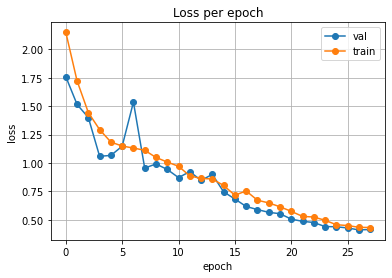

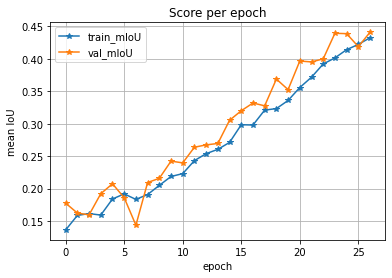

In [ ]:
plot_loss(history)
plot_score(history)

In [ ]:
#save model
torch.save(model, '/content/drive/My Drive/Colab Notebooks/models/Resnet-Unet-lovasz_0.554.pt')

# Evaluation

## Load Model

In [7]:
model_FPN = torch.load('/content/drive/My Drive/Colab Notebooks/models/FPN-efficientnet-b3(Lovasz)_mIoU-0.640.pt')
model_Unet_Mob = torch.load('/content/drive/My Drive/Colab Notebooks/models/Unet-Mobilenet_v2(lovasz)_mIoU-0.514.pt')
model_Unet_B3 = torch.load('/content/drive/My Drive/Colab Notebooks/models/Unet-efficientnet-b3_mIoU(lovasz)-0.554.pt')

## Load Test Sets

In [8]:
class Drone_Test_Data(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        """
        get item per index
        """
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask

#test set
t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)

test_set = Drone_Test_Data(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

#predict function
def predict_image_mask(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

## Result

## Plot Result

In [9]:
image, mask = test_set[2]

In [10]:
pred_mask1, score1 = predict_image_mask(model_FPN, image, mask)
pred_mask2, score2 = predict_image_mask(model_Unet_B3, image, mask)
pred_mask3, score3 = predict_image_mask(model_Unet_Mob, image, mask)

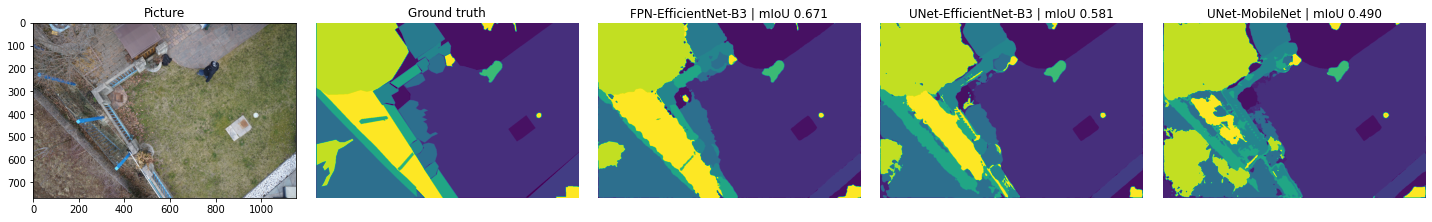

In [11]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask1)
ax3.set_title('FPN-EfficientNet-B3 | mIoU {:.3f}'.format(score1))
ax3.set_axis_off()

ax4.imshow(pred_mask2)
ax4.set_title('UNet-EfficientNet-B3 | mIoU {:.3f}'.format(score2))
ax4.set_axis_off()

ax5.imshow(pred_mask3)
ax5.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax5.set_axis_off()
fig.tight_layout()
fig.show()

## Test Score, time and accuracy

### mIoU

In [13]:
def score_all_set(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask(model, img, mask)
        score_iou.append(score)
    return score_iou

In [14]:
FPN = score_all_set(model_FPN, test_set)
UNET_B3 = score_all_set(model_Unet_B3, test_set)
UNET_mob = score_all_set(model_Unet_Mob, test_set)

In [16]:
print('FPN mIoU', np.mean(FPN))
print('Ub3 mIoU', np.mean(UNET_B3))
print('Mobile mIoU', np.mean(UNET_mob))

FPN mIoU 0.6700336346469529
Ub3 mIoU 0.6111941724254819
Mobile mIoU 0.54229969275637


### Time

In [17]:
#import time
def predict_image_time(model, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    since = time.time()
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        
        output = model(image)
        masked = torch.argmax(output, dim=1)
    return masked, time.time()-since

In [18]:
def inference_time(test_set, model):
    waktu = []
    for i in tqdm(range(len(test_set))):
        img, _ = test_set[i]
        _, times = predict_image_time(model, img)
        waktu.append(times)
    return waktu

In [19]:
FPN_time = inference_time(test_set, model_FPN)
ub3_time = inference_time(test_set, model_Unet_B3)
umb3_time = inference_time(test_set, model_Unet_Mob)

In [20]:
print('FPN mean Time', np.mean(FPN_time))
print('Ub3 mean Time', np.mean(ub3_time))
print('Mobile mean Time', np.mean(umb3_time))

FPN mean Time 0.06091806888580322
Ub3 mean Time 0.060534965991973874
Mobile mean Time 0.033977627754211426


### Pixel Accuracy

In [23]:
def predict_image_mask(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [26]:
def score_all_set(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [27]:
FPN_acc = score_all_set(model_FPN, test_set)
UB3_acc = score_all_set(model_Unet_B3, test_set)
UM2_acc = score_all_set(model_Unet_Mob, test_set)

In [28]:
print('FPN Pixel Accuracy', np.mean(FPN_acc))
print('Ub3 Pixel Accuracy', np.mean(UB3_acc))
print('Mobile Pixel Accuracy', np.mean(UM2_acc))

FPN Pixel Accuracy 0.9354644492820459
Ub3 Pixel Accuracy 0.9195874532063801
Mobile Pixel Accuracy 0.8900112010814525
